In [1]:
import os
import SimpleITK as sitk
import six
import matplotlib.pyplot as plt
import pydicom
import pydicom.data
import PyQt5
import numpy as np
np.seterr(all="ignore")
import os, glob
import pydicom
import pylab as pl
import sys
import matplotlib.path as mplPath
import keyboard
import nibabel as nib
from radiomics import featureextractor 
from radiomics import imageoperations
from IPython.core.display import display, HTML
from IPython.utils import io
import logging
from util import pyvis, make_feature_map, feature_map_mask
import nrrd
from scipy import ndimage
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [2]:
res = ['07','20','31']
nres = ['05','22','28']
ids = ['07','20','31','05','22','28']

In [3]:

%matplotlib widget
visualize = 0
level = 0
window = 500
m1 = level-window/2
m2 = level+window/2
slices = []
segs = []
qsms = []
skipcount = 0
for j in np.arange(len(ids)):
    V = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/qsm/QSM_e10_imaginary_'+ids[j]+'.nii.gz')
    M = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/seg/'+ids[j]+'.nii.gz')
    qsms.append(V.get_fdata())
    segs.append(M.get_fdata())
    rows,cols,slices = V.shape
    img_shape = (slices,rows,cols)
    plots = np.zeros(img_shape)


    for i in np.arange(slices):
        pix = V.get_fdata()[:,:,i]
        m = V.get_fdata() != -250
        pix[pix<m1]=m1
        pix[pix>m2]=m2
        # plots[i,:,:] = m[:,:,i]*pix

    if visualize == 1:
        pyvis(np.hstack((np.flip(V.get_fdata().T),np.flip(100*M.get_fdata().T))),10,10)




In [4]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.CRITICAL)
reextract = 1
rewrite = 1
# Extract predictive features only
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllImageTypes()
extractor.disableAllFeatures()
extractor.enableImageTypeByName('Original')
extractor.enableImageTypeByName('Gradient')
# extractor.enableImageTypeByName('Square')
extractor.enableImageTypeByName('Wavelet')
extractor.enableFeatureClassByName('firstorder')
# extractor.enableFeatureClassByName('glcm')
extractor.enableFeatureClassByName('gldm')
extractor.enableFeatureClassByName('glszm')
print('Enabled features:\n\t', extractor.enabledFeatures)
x_row = []
Phi = []
keylib = []
roilib = []
roi_names = np.asarray(['Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
phi_predict = ['original_gldm_LargeDependenceHighGrayLevelEmphasis','wavelet-HLL_glszm_ZoneEntropy','square_firstorder_RootMeanSquared']#,'wavelet-LLL_gldm_GrayLevelNonUniformity','gradient_glcm_SumEntropy','square_firstorder_Variance','wavelet-HHL_glszm_SizeZoneNonUniformity']
phic = '\t'.join(phi_predict)
# Convert to SITK images and extract features
os.chdir(r"maps")
if reextract == 1:
    for j in np.arange(len(ids)):
        qsm_sitk = sitk.GetImageFromArray(qsms[j]) 
        seg = np.asarray(segs[j].astype(int))
        seg_sitk = sitk.GetImageFromArray(seg) 
        for k in np.arange(1,len(roi_names)+1):
            with io.capture_output() as captured:
                featureVector = extractor.execute(qsm_sitk,seg_sitk,voxelBased=True,label=k);
                fv_count = 0
                Phi.append(featureVector)
            print('Extracted feature maps for subject',ids[j],'ROI',str(k))
       
            for key, value in six.iteritems(featureVector):
                if isinstance(value, sitk.Image):  # Feature map
                    if key in phic and rewrite == 1:
                        print('Writing '+key+' map')
                        sitk.WriteImage(value,key +'_'+ids[j]+'_'+str(k)+'.nrrd', True)
                        sitk.WriteImage(seg_sitk,key +'seg_'+ids[j]+'_'+str(k)+'.nrrd', True)
                if key == 'diagnostics_Mask-original_BoundingBox':
                    lims = value
                    # Assuming kernel radius of 3, slide of 1, and padding of 0
                    sitk.WriteImage(seg_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'seg_crop_' + ids[j] +'_'+str(k)+ '.nrrd',True)
                    sitk.WriteImage(qsm_sitk[lims[0]-1:lims[0]+lims[3]+1,lims[1]-1:lims[1]+lims[4]+1,lims[2]-1:lims[2]+lims[5]+1], 'qsm_crop_' + ids[j] +'_'+str(k)+ '.nrrd',True)
os.chdir(r"..")
       




Enabled features:
	 {'firstorder': [], 'gldm': [], 'glszm': []}
Extracted feature maps for subject 07 ROI 1
Writing original_gldm_LargeDependenceHighGrayLevelEmphasis map
Writing wavelet-HLL_glszm_ZoneEntropy map
Extracted feature maps for subject 07 ROI 2
Writing original_gldm_LargeDependenceHighGrayLevelEmphasis map
Writing wavelet-HLL_glszm_ZoneEntropy map
Extracted feature maps for subject 07 ROI 3
Writing original_gldm_LargeDependenceHighGrayLevelEmphasis map
Writing wavelet-HLL_glszm_ZoneEntropy map
Extracted feature maps for subject 07 ROI 4
Writing original_gldm_LargeDependenceHighGrayLevelEmphasis map
Writing wavelet-HLL_glszm_ZoneEntropy map
Extracted feature maps for subject 07 ROI 5
Writing original_gldm_LargeDependenceHighGrayLevelEmphasis map
Writing wavelet-HLL_glszm_ZoneEntropy map
Extracted feature maps for subject 07 ROI 6
Writing original_gldm_LargeDependenceHighGrayLevelEmphasis map
Writing wavelet-HLL_glszm_ZoneEntropy map
Extracted feature maps for subject 20 ROI 

In [6]:
# Import the maps from `.nrrd` files and visualize

feat_name = 'wavelet-HLL_glszm_ZoneEntropy'
r_num1 = 2
r_num2 = 3
pr = res[2]#[0]
pn = nres[0]#[1]

# ROI 1
hr1,gr1 = nrrd.read('./maps/'+feat_name+'_'+str(pr)+'_'+str(r_num1)+'.nrrd')
hrq1,grq1 = nrrd.read('./maps/qsm_crop_'+str(pr)+'_'+str(r_num1)+'.nrrd')
mr1,mrq1 = nrrd.read('./maps/seg_crop_'+str(pr)+'_'+str(r_num1)+'.nrrd')
hrq1 = hrq1*(abs(hr1)!=0)
hn1,gn1 = nrrd.read('./maps/'+feat_name+'_'+str(pn)+'_'+str(r_num1)+'.nrrd')
hnq1,gnq1 = nrrd.read('./maps/qsm_crop_'+str(pn)+'_'+str(r_num1)+'.nrrd')
mn1,mnq1 = nrrd.read('./maps/seg_crop_'+str(pn)+'_'+str(r_num1)+'.nrrd')
hnq1 = hnq1*(abs(hn1)!=0)
# ROI 2
hr2,gr2 = nrrd.read('./maps/'+feat_name+'_'+str(pr)+'_'+str(r_num2)+'.nrrd')
hrq2,grq2 = nrrd.read('./maps/qsm_crop_'+str(pr)+'_'+str(r_num2)+'.nrrd')
mr2,mrq2 = nrrd.read('./maps/seg_crop_'+str(pr)+'_'+str(r_num2)+'.nrrd')
hrq2 = hrq2*(abs(hr2)!=0)
hn2,gn2 = nrrd.read('./maps/'+feat_name+'_'+str(pn)+'_'+str(r_num2)+'.nrrd')
hnq2,gnq2 = nrrd.read('./maps/qsm_crop_'+str(pn)+'_'+str(r_num2)+'.nrrd')
mn2,mnq2 = nrrd.read('./maps/seg_crop_'+str(pn)+'_'+str(r_num2)+'.nrrd')
hnq2 = hnq2*(abs(hn2)!=0)
#pyvis(np.hstack((np.flip(seg.T)*np.flip(sitk.GetArrayFromImage(sitk.GradientMagnitude(qsm_sitk)).T),np.flip(sitk.GetArrayFromImage(sitk.GradientMagnitude(qsm_sitk)).T))),10,10,'gray')

In [7]:
# Responder
px,py,pz = np.asarray(hrq1.shape)-np.asarray(hrq2.shape)
px,py,pz
hrq1p = np.pad(hrq1,((0,abs(min(0,px))),(0,abs(min(0,py))),(0,abs(min(0,pz)))))
hrq2p = np.pad(hrq2,((0,abs(max(0,px))),(0,abs(max(0,py))),(0,abs(max(0,pz)))))
hr1p = np.pad(hr1,((0,abs(min(0,px))),(0,abs(min(0,py))),(0,abs(min(0,pz)))))
hr2p = np.pad(hr2,((0,abs(max(0,px))),(0,abs(max(0,py))),(0,abs(max(0,pz)))))

# Non-responder
px,py,pz = np.asarray(hnq1.shape)-np.asarray(hnq2.shape)
px,py,pz
hnq1p = np.pad(hnq1,((0,abs(min(0,px))),(0,abs(min(0,py))),(0,abs(min(0,pz)))))
hnq2p = np.pad(hnq2,((0,abs(max(0,px))),(0,abs(max(0,py))),(0,abs(max(0,pz)))))
hn1p = np.pad(hn1,((0,abs(min(0,px))),(0,abs(min(0,py))),(0,abs(min(0,pz)))))
hn2p = np.pad(hn2,((0,abs(max(0,px))),(0,abs(max(0,py))),(0,abs(max(0,pz)))))


In [8]:
# Responder map and QSM
hr = np.flipud(np.concatenate((hr1p,hr2p),axis=2))
hrq = np.flipud(np.concatenate((hrq1p,hrq2p),axis=2))
# Non-responder map and QSM
hn = np.flipud(np.concatenate((hn1p,hn2p),axis=2))
hnq = np.flipud(np.concatenate((hnq1p,hnq2p),axis=2))
# Dimension difference
px,py,pz = np.asarray(hr.shape)-np.asarray(hn.shape)
print(px,py,pz)
# Padded responder
hrp = np.pad(hr,((0,abs(min(0,px))),(0,abs(min(0,py))),(0,abs(min(0,pz)))))
hrqp = np.pad(hrq,((0,abs(min(0,px))),(0,abs(min(0,py))),(0,abs(min(0,pz)))))
# Padded non-responder
hnp = np.pad(hn,((0,abs(max(0,px))),(0,abs(max(0,py))),(0,abs(max(0,pz)))))
hnqp = np.pad(hnq,((0,abs(max(0,px))),(0,abs(max(0,py))),(0,abs(max(0,pz)))))


1 0 -2


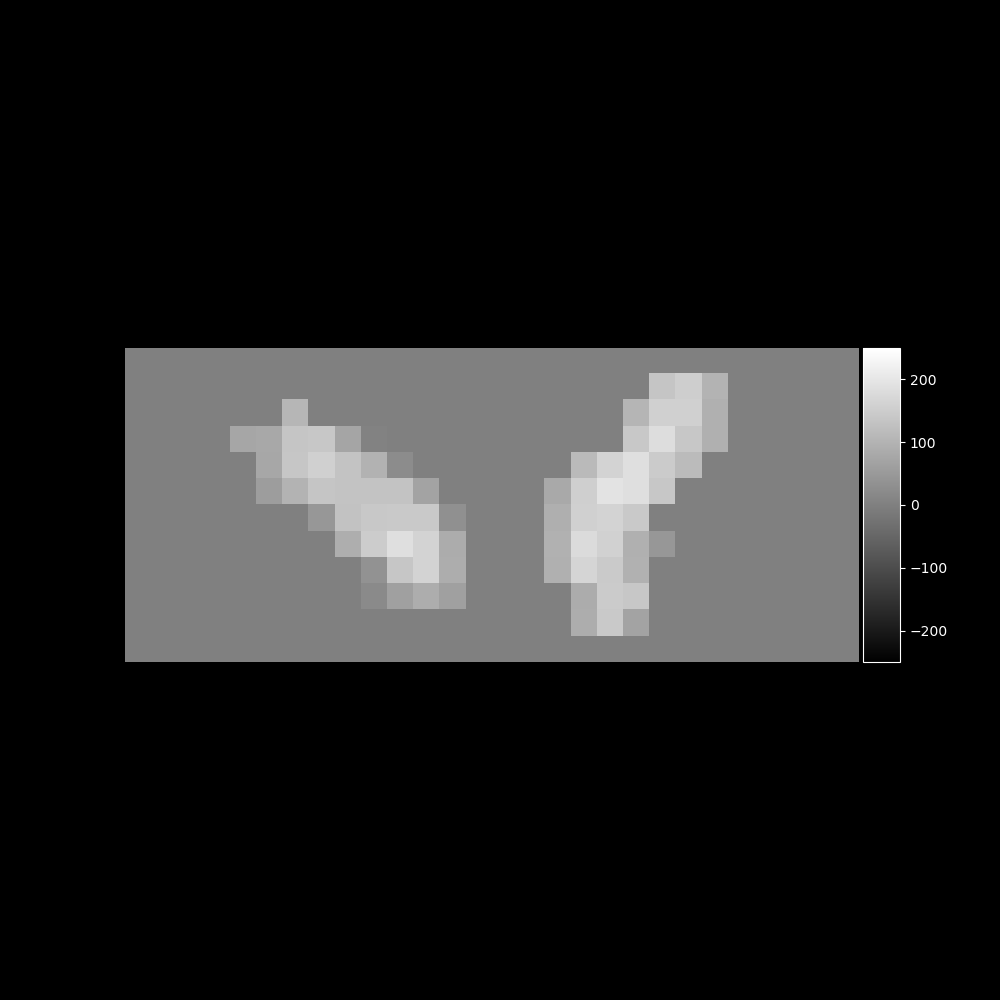

In [9]:
mask = feature_map_mask(res[2],'maps/'+feat_name,True,[r_num1,r_num2])
make_feature_map(res[2],'maps/'+'qsm_crop',mask,[r_num1,r_num2],500,0,-250,250)

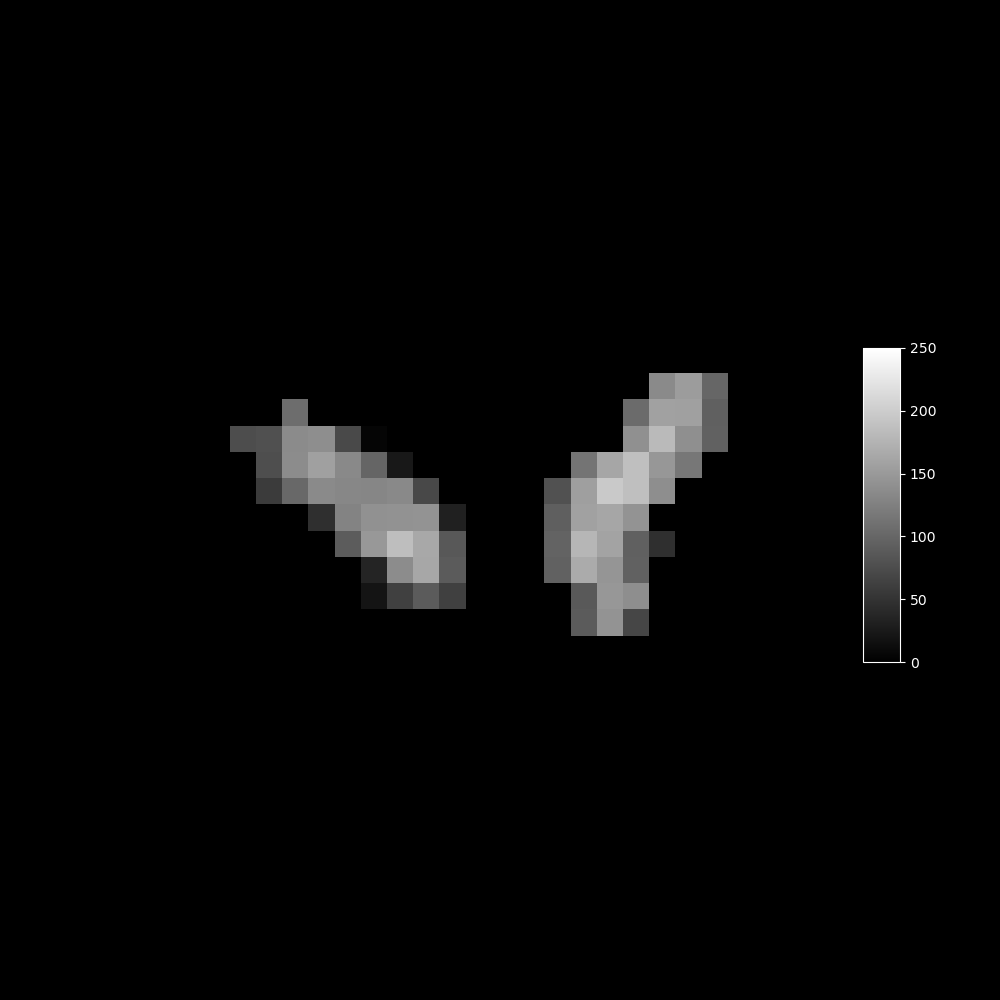

In [10]:
make_feature_map(res[2],'maps/'+feat_name,mask,[r_num1,r_num2],500,0,0,250)

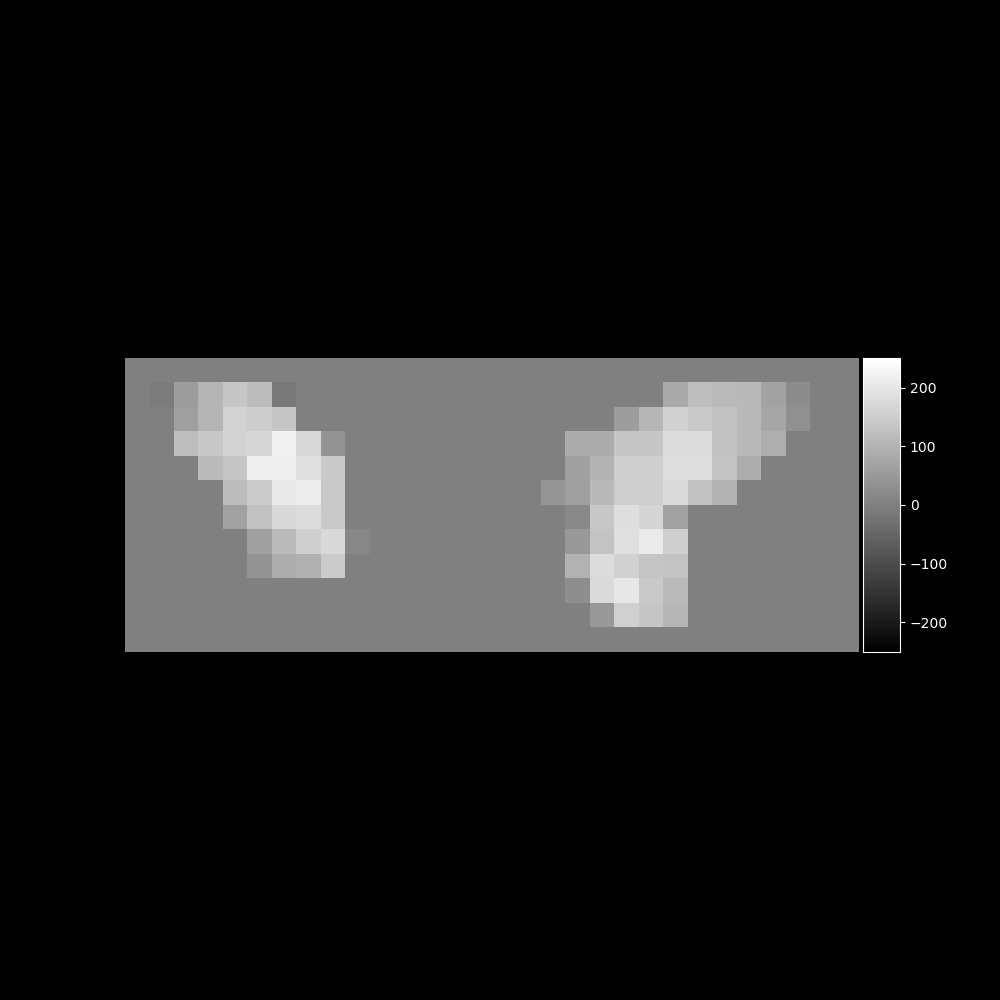

In [15]:
mask = feature_map_mask(nres[0],'maps/'+feat_name,True,[r_num1,r_num2])
make_feature_map(nres[0],'maps/'+'qsm_crop',mask,[r_num1,r_num2],500,0,-250,250)

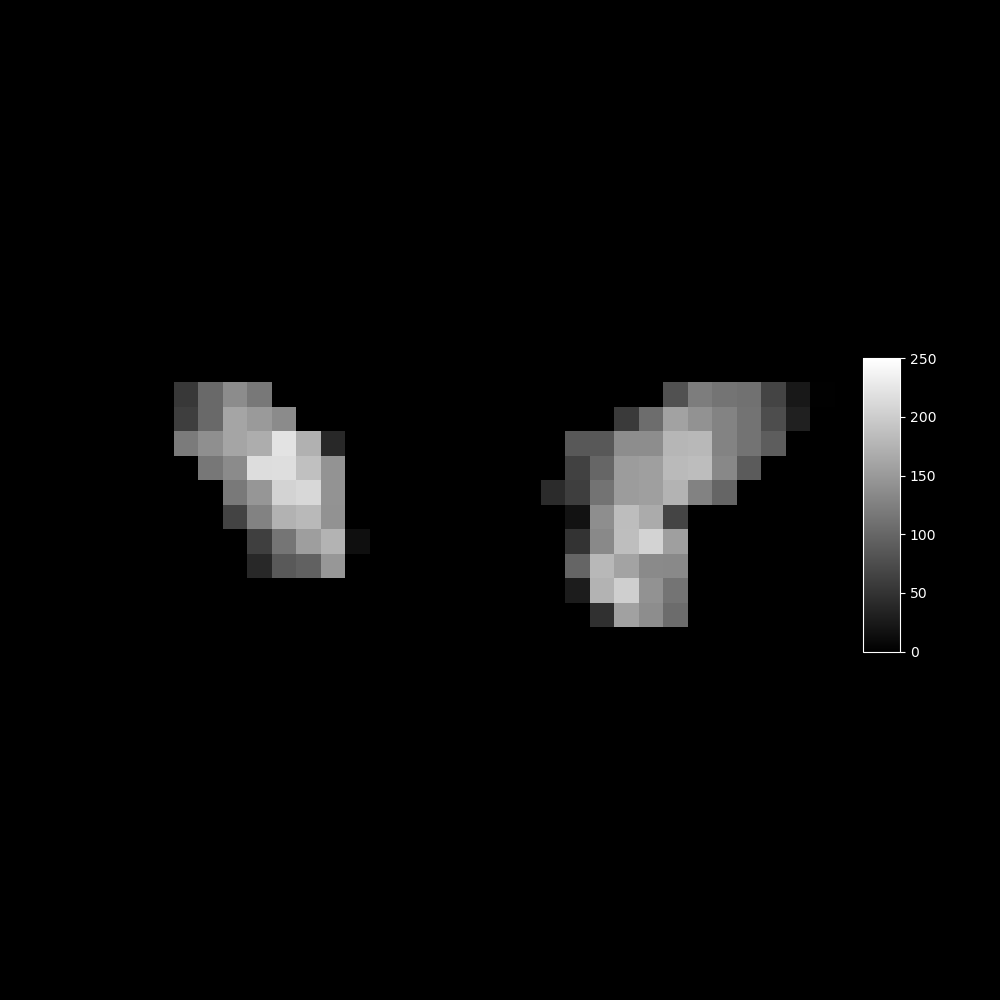

In [18]:
make_feature_map(nres[0],'maps/'+feat_name,mask,[r_num1,r_num2],500,0,0,250)